In [20]:
# Import packages
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [21]:
# Load the data
df2021 = pd.read_csv('data/shelter/daily-shelter-overnight-service-occupancy-capacity-2021.csv')
df2022 = pd.read_csv('data/shelter/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
df2023 = pd.read_csv('data/shelter/daily-shelter-overnight-occupancy.csv') 

# Unify year format
df2021['OCCUPANCY_DATE'] = df2021['OCCUPANCY_DATE'].apply(lambda x: '2021' + x[2:] if x.startswith('21') else x)
df2022['OCCUPANCY_DATE'] = df2022['OCCUPANCY_DATE'].apply(lambda x: '2022' + x[2:] if x.startswith('22') else x)

# Concatenate the dataframes
df = pd.concat([df2021, df2022, df2023], ignore_index=True)

# Process date column
df["OCCUPANCY_DATE"] = pd.to_datetime(df["OCCUPANCY_DATE"])
df["year"] = df["OCCUPANCY_DATE"].dt.year
df["month"] = df["OCCUPANCY_DATE"].dt.month
df["day"] = df["OCCUPANCY_DATE"].dt.day
df = df.drop(columns=["OCCUPANCY_DATE"])

# Get occupancy rate
df['OCCUPANCY_RATE'] = np.where(df['CAPACITY_TYPE'] == 'Bed Based Capacity', df['OCCUPANCY_RATE_BEDS'], np.where(df['CAPACITY_TYPE'] == 'Room Based Capacity', df['OCCUPANCY_RATE_ROOMS'], np.nan))

# Drop columns that are not useful
df = df.drop(
    columns=[
        "ORGANIZATION_NAME",
        "SHELTER_GROUP",
        "LOCATION_NAME",
        "LOCATION_ADDRESS",
        "LOCATION_POSTAL_CODE",
        "LOCATION_CITY",
        "LOCATION_PROVINCE",
        "PROGRAM_NAME",
        "CAPACITY_ACTUAL_BED",
        "CAPACITY_FUNDING_BED",
        "OCCUPIED_BEDS",
        "UNOCCUPIED_BEDS",
        "UNAVAILABLE_BEDS",
        "CAPACITY_TYPE",
        "CAPACITY_ACTUAL_ROOM",
        "CAPACITY_FUNDING_ROOM",
        "OCCUPIED_ROOMS",
        "UNOCCUPIED_ROOMS",
        "UNAVAILABLE_ROOMS",
        "OCCUPANCY_RATE_BEDS",
        "OCCUPANCY_RATE_ROOMS",
    ]
)

In [22]:
# Combine year, month, and day into a single date column
df['ds'] = pd.to_datetime(df[['year', 'month', 'day']])

# Rename the occupancy rate column to 'y' to comply with Prophet's naming convention
df = df.rename(columns={'OCCUPANCY_RATE': 'y'})

# Drop the year, month, and day columns as they are no longer needed
df = df.drop(columns=['year', 'month', 'day'])

In [30]:
df['cap'] = 100.0
df['floor'] =0.0

In [ ]:
# Get a list of unique location IDs
location_ids = df['LOCATION_ID'].unique()

# Dictionary to store the forecasts
forecasts_dict = {}

for location_id in location_ids:
    # Filter the data for the current location
    location_data = df[df['LOCATION_ID'] == location_id]

    non_nan_rows = location_data['y'].notna().sum()
    
    if non_nan_rows < 2:
        continue  # Skip this location
    
    # Drop the LOCATION_ID column as it's not needed for modeling
    location_data = location_data.drop(columns=['LOCATION_ID'])
    
    # Create and fit the Prophet model with logistic growth
    model = Prophet(growth='logistic', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(location_data)
    
    # Create future dates for prediction, including the cap and floor
    future = model.make_future_dataframe(periods=365)  # Predict the next year
    future['cap'] = 100.0
    future['floor'] = 0.0
    
    # Make predictions
    forecast = model.predict(future)
    
    # Store the forecast in the dictionary
    forecasts_dict[location_id] = forecast

In [39]:
#see how many rows have nan as LOCATION_ID
num_nan_rows = df['LOCATION_ID'].isna().sum()
display(num_nan_rows)

450

In [37]:
print(location_ids)

[1103. 1051. 1114. 1160. 1172. 1029. 1102. 1052. 1070. 1183. 1184. 1185.
 1186. 1009. 1181. 1182. 1065. 1066. 1067. 1011. 1123. 1069. 1163. 1155.
 1151. 1154. 1008.   nan 1004. 1124. 1005. 1006. 1028. 1169. 1026. 1027.
 1149. 1157. 1176. 1015. 1167. 1177. 1020. 1025. 1174. 1024. 1023. 1053.
 1054. 1099. 1081. 1130. 1055. 1152. 1187. 1022. 1021. 1168. 1108. 1150.
 1179. 1125. 1031. 1153. 1033. 1019. 1173. 1080. 1118. 1002. 1013. 1018.
 1050. 1049. 1048. 1039. 1105. 1148. 1178. 1038. 1045. 1180. 1132. 1059.
 1036. 1175. 1037. 1166. 1057. 1126. 1146. 1014. 1120. 1041. 1115. 1035.
 1001. 1096. 1101. 1062. 1171. 1064. 1147. 1190. 1104. 1193. 1191. 1192.
 1128. 1007. 1194. 1198. 1195. 1129. 1200. 1220. 1240. 1158. 1280. 1300.
 1320. 1360. 1380. 1400. 1078. 1189. 1420. 1440. 1460. 1480. 1500.]


In [32]:
location_id_1103 = location_ids[0]
forecast_location_1103 = forecasts_dict[location_id_1103]
# check the forecast for location 1103 data
print(forecast_location_1103)

             ds      trend    cap  floor  yhat_lower  yhat_upper  trend_lower  \
0    2021-01-01  95.770108  100.0    0.0   86.602087  103.684855    95.770108   
1    2021-01-02  95.776943  100.0    0.0   86.191023  103.663309    95.776943   
2    2021-01-03  95.783768  100.0    0.0   86.623562  104.652741    95.783768   
3    2021-01-04  95.790582  100.0    0.0   86.561099  104.690979    95.790582   
4    2021-01-05  95.797386  100.0    0.0   85.759753  104.339380    95.797386   
...         ...        ...    ...    ...         ...         ...          ...   
1374 2024-10-06  99.530343  100.0    0.0   90.527176  108.240322    99.529100   
1375 2024-10-07  99.531103  100.0    0.0   90.178530  108.247174    99.529859   
1376 2024-10-08  99.531861  100.0    0.0   89.804563  106.937323    99.530616   
1377 2024-10-09  99.532619  100.0    0.0   90.027967  107.726863    99.531373   
1378 2024-10-10  99.533375  100.0    0.0   89.829283  108.020071    99.532123   

      trend_upper  additive

22:28:06 - cmdstanpy - INFO - Chain [1] start processing
22:28:07 - cmdstanpy - INFO - Chain [1] done processing


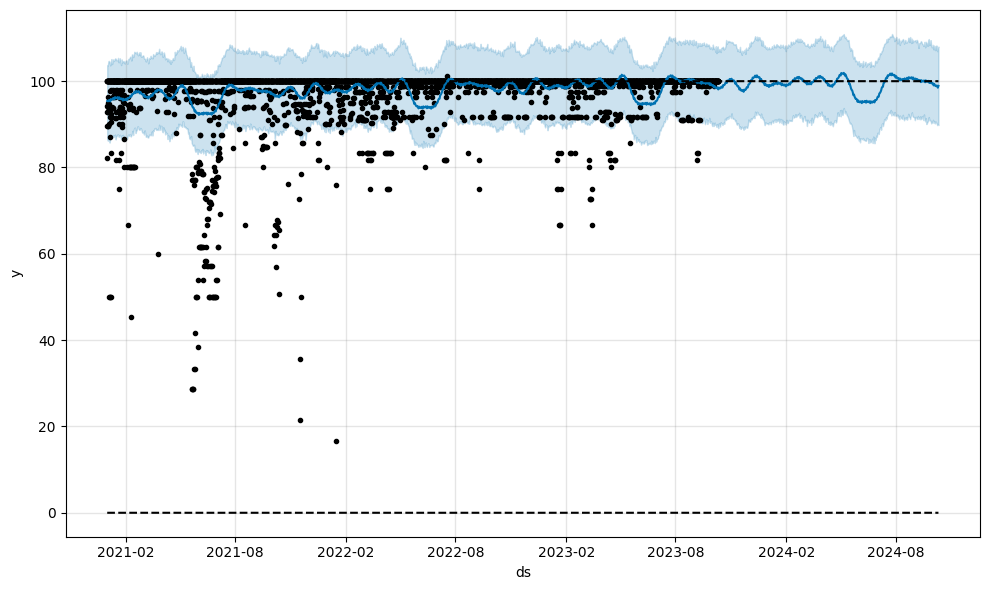

In [40]:
model_location_1103 = Prophet(growth='logistic', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_location_1103.fit(df[df['LOCATION_ID'] == location_id_1103].drop(columns=['LOCATION_ID']))
fig_location_1103 = model_location_1103.plot(forecast_location_1103)

# Display the plot
plt.show()

22:28:14 - cmdstanpy - INFO - Chain [1] start processing
22:28:14 - cmdstanpy - INFO - Chain [1] done processing


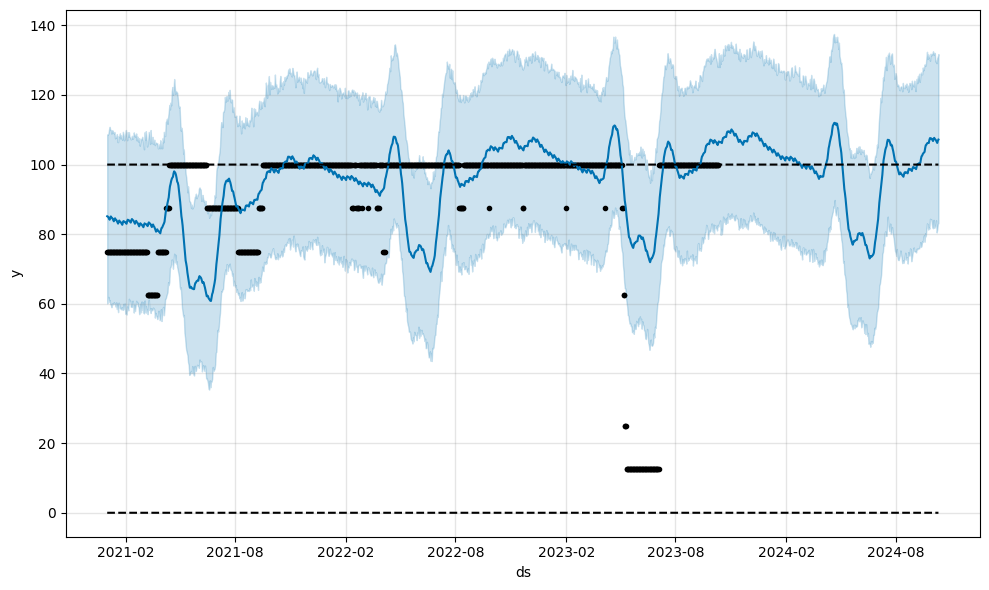

In [41]:
location_id_1051 = location_ids[1]
forecast_location_1051 = forecasts_dict[location_id_1051]
model_location_1051 = Prophet(growth='logistic', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_location_1051.fit(df[df['LOCATION_ID'] == location_id_1051].drop(columns=['LOCATION_ID']))
fig_location_1051 = model_location_1051.plot(forecast_location_1051)

# Display the plot
plt.show()